Pipeline to Get 1D Spectra from Raw Data (IRD Stream)
=====================================================

This tutorial demonstrates how to reduce raw data to wavelength-calibrated 1D spectra. 
By using the `Stream2D` framework, you can apply functions to multiple FITS files efficiently.

The same pipeline is available in `examples/python/IRD_stream.py`.
For REACH data, refer the script available in `examples/python/REACH_stream.py`.

- :ref:`step0`
- :ref:`step1`
    - :ref:`step1-1`
    - :ref:`step1-2` 
    - :ref:`step1-3`
    - :ref:`step1-4`
- :ref:`step2`
    - :ref:`step2-1`
    - :ref:`step2-2`
    - :ref:`step2-3`
    - :ref:`step2-4`
    - :ref:`step2-5`

.. _step0: 

## Step 0: Settings
### Directory Structure

First, specify the path to the raw data directory (`datadir`) and the output directory (`anadir`)

This tutorial assumes the following directory structure:
```
.
└── pyird/
    └── data/
        └── 20210317/
            ├── flat
            ├── thar
            ├── target
            ├── dark
            └── reduc
```
In this structure, the flat, thar, target, and dark directories are part of the `datadir`, each containing raw data for 'Flat', 'ThAr', 'Target', and optionally 'Dark' frames. 
The reduc directory is used as `anadir` for storing processed data.

In [1]:
import pathlib
basedir = pathlib.Path('~/pyird/data/20210317/').expanduser()

datadir_flat = basedir/'flat/'
datadir_dark = basedir/'dark/'
datadir_thar = basedir/'thar'
datadir_target = basedir/'target/'
anadir = basedir/'reduc/'

### Specify the Data to be Analyzed

Please change the following variables based on the data you want to analyze.
The sample data can be downloaded from the `Zenodo repository <https://zenodo.org/records/14614004>`_

In [2]:
band = 'h' #'h' or 'y'
mmf = 'mmf2' #'mmf1' (comb fiber) or 'mmf2' (star fiber)
readout_noise_mode = 'default'

# file numbers of fits files (last five digits)
fitsid_flat_comb = list(range(41704,41804,2)) 
fitsid_flat_star = list(range(41804,41904,2)) 
fitsid_dark = [41504]
fitsid_thar = list(range(14632,14732))
fitsid_target = [41510]

**Note**:

Ensure that the `readout_noise_mode` is set to either 'real' or 'default'.

- `readout_noise_mode = 'real'`: Need to reduce the dataset with `band = 'y'` and `mmf = 'mmf1'` at first.
    - With this setting, uncertainties and signal-to-noise ratio at each wavelength will be included in the output files (**nw..._m?.dat** and **ncw..._m?.dat**).
    - Those values are based on the readout noise (RN) calculated using the comb spectrum (in mmf1) of the Y/J band.

- `readout_noise_mode = 'default'`: Uses a default readout noise (RN) value (RN=12 $e^{-}$).

.. _step1:

## Step 1: Preprocessing the Calibration Dataset

<img src="../figures/reduc_flowchart_calib.png" width=80%>

.. _step1-1:

### Step 1-1: Identifying Apertures (Spectral Orders)

- The `aptrace` function is used to identify apertures.
- Number of apertures (`nap`): 42 for H band, 102 for Y/J band.
- ``cutrow`` sets the initial row number on the detector image for searching apertures.
- These apertures are identified in the FLAT_COMB data.
- If your observation was performed with a single fiber, set `nap` to half the default value.

fitsid: [41704, 41706, 41708, 41710, 41712, 41714, 41716, 41718, 41720, 41722, 41724, 41726, 41728, 41730, 41732, 41734, 41736, 41738, 41740, 41742, 41744, 41746, 41748, 41750, 41752, 41754, 41756, 41758, 41760, 41762, 41764, 41766, 41768, 41770, 41772, 41774, 41776, 41778, 41780, 41782, 41784, 41786, 41788, 41790, 41792, 41794, 41796, 41798, 41800, 41802]
fitsid incremented:  [41705, 41707, 41709, 41711, 41713, 41715, 41717, 41719, 41721, 41723, 41725, 41727, 41729, 41731, 41733, 41735, 41737, 41739, 41741, 41743, 41745, 41747, 41749, 41751, 41753, 41755, 41757, 41759, 41761, 41763, 41765, 41767, 41769, 41771, 41773, 41775, 41777, 41779, 41781, 41783, 41785, 41787, 41789, 41791, 41793, 41795, 41797, 41799, 41801, 41803]
median combine:  



  0%|                                                                                                                                                            | 0/50 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1054.97it/s]

default nap value
cross-section: row  1301


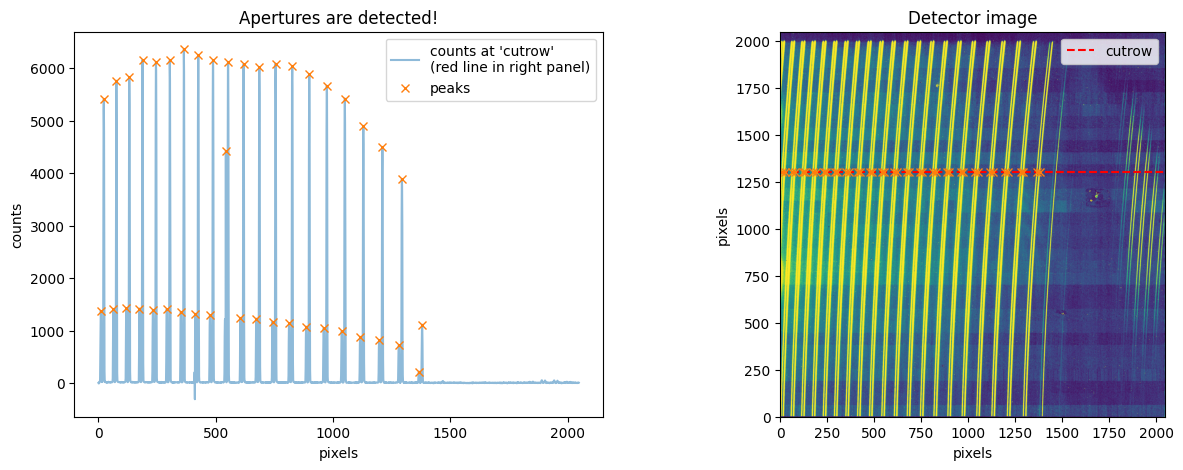


  0%|                                                                                                                                                            | 0/42 [00:00<?, ?it/s]


  2%|███▌                                                                                                                                                | 1/42 [00:00<00:06,  6.07it/s]


  5%|███████                                                                                                                                             | 2/42 [00:00<00:06,  6.18it/s]


  7%|██████████▌                                                                                                                                         | 3/42 [00:00<00:06,  6.23it/s]


 10%|██████████████                                                                                                                                      | 4/42 [00:00<00:06,  6.29it/s]


 12%|█████████████████▌                                                                                                                                  | 5/42 [00:00<00:05,  6.34it/s]


 14%|█████████████████████▏                                                                                                                              | 6/42 [00:00<00:05,  6.46it/s]


 17%|████████████████████████▋                                                                                                                           | 7/42 [00:01<00:05,  6.39it/s]


 19%|████████████████████████████▏                                                                                                                       | 8/42 [00:01<00:05,  6.44it/s]


 21%|███████████████████████████████▋                                                                                                                    | 9/42 [00:01<00:05,  6.48it/s]


 24%|███████████████████████████████████                                                                                                                | 10/42 [00:01<00:04,  6.47it/s]


 26%|██████████████████████████████████████▌                                                                                                            | 11/42 [00:01<00:04,  6.48it/s]


 29%|██████████████████████████████████████████                                                                                                         | 12/42 [00:01<00:04,  6.54it/s]


 31%|█████████████████████████████████████████████▌                                                                                                     | 13/42 [00:02<00:04,  6.52it/s]


 33%|█████████████████████████████████████████████████                                                                                                  | 14/42 [00:02<00:04,  6.57it/s]


 36%|████████████████████████████████████████████████████▌                                                                                              | 15/42 [00:02<00:04,  6.62it/s]


 38%|████████████████████████████████████████████████████████                                                                                           | 16/42 [00:02<00:03,  6.64it/s]


 40%|███████████████████████████████████████████████████████████▌                                                                                       | 17/42 [00:02<00:03,  6.63it/s]


 43%|███████████████████████████████████████████████████████████████                                                                                    | 18/42 [00:02<00:03,  6.61it/s]


 45%|██████████████████████████████████████████████████████████████████▌                                                                                | 19/42 [00:02<00:03,  6.57it/s]


 48%|██████████████████████████████████████████████████████████████████████                                                                             | 20/42 [00:03<00:03,  6.53it/s]


 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 21/42 [00:03<00:03,  6.61it/s]


 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 22/42 [00:03<00:03,  6.63it/s]


 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                  | 23/42 [00:03<00:02,  6.59it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 24/42 [00:03<00:02,  6.59it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                           | 25/42 [00:03<00:02,  6.65it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 26/42 [00:03<00:02,  6.65it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 27/42 [00:04<00:02,  6.63it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 28/42 [00:04<00:02,  6.66it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 29/42 [00:04<00:01,  6.59it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 30/42 [00:04<00:01,  6.54it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 31/42 [00:04<00:01,  6.57it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 32/42 [00:04<00:01,  6.60it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 33/42 [00:05<00:01,  6.57it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 34/42 [00:05<00:01,  6.61it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 35/42 [00:05<00:01,  6.63it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 36/42 [00:05<00:00,  6.60it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 37/42 [00:05<00:00,  6.60it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 38/42 [00:05<00:00,  6.61it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 39/42 [00:05<00:00,  6.58it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 40/42 [00:06<00:00,  6.55it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 41/42 [00:06<00:00,  6.56it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]

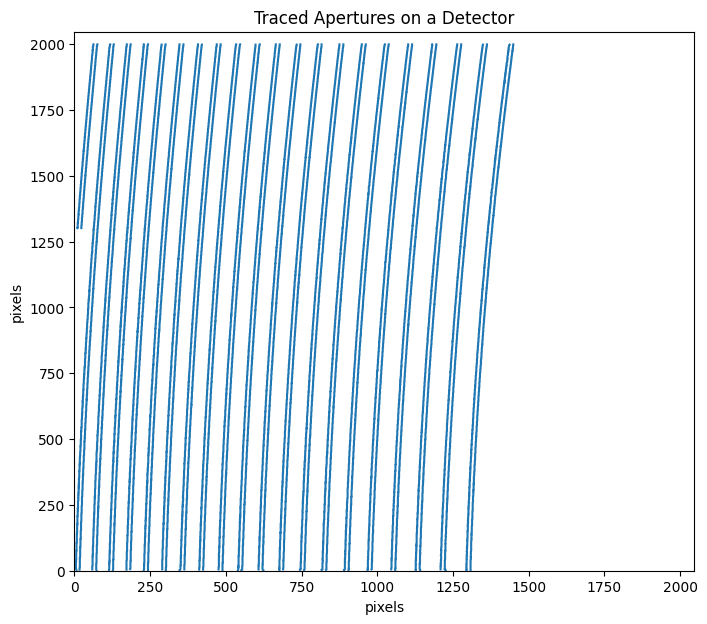

In [3]:
from pyird.utils import irdstream

## FLAT_COMB
# settings
flat_comb = irdstream.Stream2D("flat_comb", datadir_flat, anadir, fitsid=fitsid_flat_comb, band=band)

# aperture extraction
if band=='h':
    trace_mmf=flat_comb.aptrace(cutrow = 1300,nap=42) 
elif band=='y':
    trace_mmf=flat_comb.aptrace(cutrow = 1000,nap=102) 

- Define 'trace_mask' to mask light from both fibers.
- Aperture width is 6 pixels (from -2 to +4) for IRD data and 5 pixels (from -2 to 3) for REACH data by default. You can change it `.width` instance of trace_mmf.

In [4]:
trace_mask = trace_mmf.mask()


  0%|                                                                                                                                                            | 0/42 [00:00<?, ?it/s]


 38%|███████████████████████████████████████████████████████▌                                                                                          | 16/42 [00:00<00:00, 151.17it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 32/42 [00:00<00:00, 145.22it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 147.27it/s]

- Reduce apertures in the mask to extract the spectrum from the desired fiber

In [5]:
trace_mmf.choose_aperture(fiber=mmf)

.. _step1-2:

### Step 1-2: Removing hotpixels

- There are two options for creating the hotpixel mask.
- This tutorial introduces one method using dark data.
- Refer to `pyird.io.read_hotpix <https://secondearths.sakura.ne.jp/pyird/pyird/pyird.io.html#module-pyird.io.read_hotpix>`_ module for an alternative approach without dark data.

In [6]:
from pyird.image.bias import bias_subtract_image
from pyird.image.hotpix import identify_hotpix_sigclip

## HOTPIXEL MASK: 
## DARK
dark = irdstream.Stream2D('dark', datadir_dark, anadir, fitsid=fitsid_dark, band=band) # Multiple file is ok
median_image = dark.immedian()
im_subbias = bias_subtract_image(median_image)
hotpix_mask = identify_hotpix_sigclip(im_subbias)

fitsid: [41504]
fitsid incremented:  [41505]
median combine:  



  0%|                                                                                                                                                             | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 133.92it/s]

hotpix mask = 0.58 percent


.. _step1-3:

### Step 1-3: Wavelength Calibration


- Wavelength calibration is performed by using reference frames (Thrium-Argon).
- You do not need to manually identify emission lines; ``calibrate_wavelength`` automatically references the line list!

fitsid: [14632, 14633, 14634, 14635, 14636, 14637, 14638, 14639, 14640, 14641, 14642, 14643, 14644, 14645, 14646, 14647, 14648, 14649, 14650, 14651, 14652, 14653, 14654, 14655, 14656, 14657, 14658, 14659, 14660, 14661, 14662, 14663, 14664, 14665, 14666, 14667, 14668, 14669, 14670, 14671, 14672, 14673, 14674, 14675, 14676, 14677, 14678, 14679, 14680, 14681, 14682, 14683, 14684, 14685, 14686, 14687, 14688, 14689, 14690, 14691, 14692, 14693, 14694, 14695, 14696, 14697, 14698, 14699, 14700, 14701, 14702, 14703, 14704, 14705, 14706, 14707, 14708, 14709, 14710, 14711, 14712, 14713, 14714, 14715, 14716, 14717, 14718, 14719, 14720, 14721, 14722, 14723, 14724, 14725, 14726, 14727, 14728, 14729, 14730, 14731]
clean_pattern: output extension=_cp



  0%|                                                                                                                                                           | 0/100 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                 | 1/100 [00:00<01:15,  1.32it/s]


  2%|██▉                                                                                                                                                | 2/100 [00:01<01:15,  1.31it/s]


  3%|████▍                                                                                                                                              | 3/100 [00:02<01:13,  1.32it/s]


  4%|█████▉                                                                                                                                             | 4/100 [00:03<01:18,  1.22it/s]


  5%|███████▎                                                                                                                                           | 5/100 [00:04<01:20,  1.18it/s]


  6%|████████▊                                                                                                                                          | 6/100 [00:05<01:23,  1.13it/s]


  7%|██████████▎                                                                                                                                        | 7/100 [00:05<01:23,  1.11it/s]


  8%|███████████▊                                                                                                                                       | 8/100 [00:06<01:19,  1.16it/s]


  9%|█████████████▏                                                                                                                                     | 9/100 [00:07<01:15,  1.21it/s]


 10%|██████████████▌                                                                                                                                   | 10/100 [00:08<01:13,  1.22it/s]


 11%|████████████████                                                                                                                                  | 11/100 [00:09<01:10,  1.27it/s]


 12%|█████████████████▌                                                                                                                                | 12/100 [00:09<01:13,  1.20it/s]


 13%|██████████████████▉                                                                                                                               | 13/100 [00:10<01:15,  1.14it/s]


 14%|████████████████████▍                                                                                                                             | 14/100 [00:11<01:13,  1.16it/s]


 15%|█████████████████████▉                                                                                                                            | 15/100 [00:12<01:12,  1.18it/s]


 16%|███████████████████████▎                                                                                                                          | 16/100 [00:13<01:06,  1.26it/s]


 17%|████████████████████████▊                                                                                                                         | 17/100 [00:13<01:02,  1.33it/s]


 18%|██████████████████████████▎                                                                                                                       | 18/100 [00:14<01:03,  1.29it/s]


 19%|███████████████████████████▋                                                                                                                      | 19/100 [00:15<00:59,  1.36it/s]


 20%|█████████████████████████████▏                                                                                                                    | 20/100 [00:16<01:01,  1.31it/s]


 21%|██████████████████████████████▋                                                                                                                   | 21/100 [00:17<01:01,  1.28it/s]


 22%|████████████████████████████████                                                                                                                  | 22/100 [00:17<01:01,  1.26it/s]


 23%|█████████████████████████████████▌                                                                                                                | 23/100 [00:18<01:01,  1.25it/s]


 24%|███████████████████████████████████                                                                                                               | 24/100 [00:19<00:57,  1.33it/s]


 25%|████████████████████████████████████▌                                                                                                             | 25/100 [00:19<00:54,  1.38it/s]


 26%|█████████████████████████████████████▉                                                                                                            | 26/100 [00:20<00:51,  1.42it/s]


 27%|███████████████████████████████████████▍                                                                                                          | 27/100 [00:21<00:53,  1.36it/s]


 28%|████████████████████████████████████████▉                                                                                                         | 28/100 [00:22<00:55,  1.29it/s]


 29%|██████████████████████████████████████████▎                                                                                                       | 29/100 [00:23<00:56,  1.26it/s]


 30%|███████████████████████████████████████████▊                                                                                                      | 30/100 [00:23<00:56,  1.24it/s]


 31%|█████████████████████████████████████████████▎                                                                                                    | 31/100 [00:24<00:52,  1.31it/s]


 32%|██████████████████████████████████████████████▋                                                                                                   | 32/100 [00:25<00:49,  1.37it/s]


 33%|████████████████████████████████████████████████▏                                                                                                 | 33/100 [00:25<00:46,  1.43it/s]


 34%|█████████████████████████████████████████████████▋                                                                                                | 34/100 [00:26<00:49,  1.34it/s]


 35%|███████████████████████████████████████████████████                                                                                               | 35/100 [00:27<00:50,  1.30it/s]


 36%|████████████████████████████████████████████████████▌                                                                                             | 36/100 [00:28<00:50,  1.27it/s]


 37%|██████████████████████████████████████████████████████                                                                                            | 37/100 [00:29<00:50,  1.24it/s]


 38%|███████████████████████████████████████████████████████▍                                                                                          | 38/100 [00:29<00:47,  1.31it/s]


 39%|████████████████████████████████████████████████████████▉                                                                                         | 39/100 [00:30<00:44,  1.36it/s]


 40%|██████████████████████████████████████████████████████████▍                                                                                       | 40/100 [00:31<00:42,  1.41it/s]


 41%|███████████████████████████████████████████████████████████▊                                                                                      | 41/100 [00:31<00:41,  1.42it/s]


 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 42/100 [00:32<00:43,  1.35it/s]


 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 43/100 [00:33<00:44,  1.30it/s]


 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 44/100 [00:34<00:44,  1.27it/s]


 45%|█████████████████████████████████████████████████████████████████▋                                                                                | 45/100 [00:35<00:44,  1.25it/s]


 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 46/100 [00:35<00:40,  1.32it/s]


 47%|████████████████████████████████████████████████████████████████████▌                                                                             | 47/100 [00:36<00:38,  1.37it/s]


 48%|██████████████████████████████████████████████████████████████████████                                                                            | 48/100 [00:37<00:36,  1.41it/s]


 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 49/100 [00:37<00:35,  1.45it/s]


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 50/100 [00:38<00:36,  1.37it/s]


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                       | 51/100 [00:39<00:37,  1.31it/s]


 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 52/100 [00:40<00:37,  1.27it/s]


 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 53/100 [00:41<00:37,  1.25it/s]


 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 54/100 [00:41<00:35,  1.31it/s]


 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                 | 55/100 [00:42<00:32,  1.37it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 56/100 [00:43<00:31,  1.41it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 57/100 [00:43<00:29,  1.45it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                             | 58/100 [00:44<00:30,  1.36it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                           | 59/100 [00:45<00:31,  1.31it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 60/100 [00:46<00:31,  1.28it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                         | 61/100 [00:47<00:31,  1.26it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 62/100 [00:47<00:28,  1.33it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 63/100 [00:48<00:27,  1.36it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 64/100 [00:49<00:25,  1.39it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 65/100 [00:49<00:24,  1.42it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 66/100 [00:50<00:25,  1.34it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 67/100 [00:51<00:25,  1.30it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 68/100 [00:52<00:25,  1.27it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 69/100 [00:53<00:24,  1.26it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 70/100 [00:53<00:22,  1.33it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 71/100 [00:54<00:20,  1.39it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 72/100 [00:55<00:19,  1.43it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 73/100 [00:55<00:19,  1.36it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 74/100 [00:56<00:19,  1.31it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 75/100 [00:57<00:19,  1.28it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 76/100 [00:58<00:18,  1.27it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 77/100 [00:59<00:17,  1.30it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 78/100 [00:59<00:16,  1.36it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 79/100 [01:00<00:14,  1.41it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 80/100 [01:01<00:14,  1.34it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 81/100 [01:02<00:15,  1.26it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 82/100 [01:03<00:14,  1.24it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 83/100 [01:03<00:13,  1.22it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 84/100 [01:04<00:12,  1.30it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 85/100 [01:05<00:11,  1.35it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 86/100 [01:05<00:10,  1.39it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 87/100 [01:06<00:10,  1.25it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 88/100 [01:07<00:09,  1.23it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 89/100 [01:08<00:09,  1.22it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 90/100 [01:09<00:08,  1.21it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 91/100 [01:10<00:07,  1.21it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 92/100 [01:11<00:07,  1.11it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 93/100 [01:11<00:05,  1.20it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 94/100 [01:12<00:04,  1.28it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [01:13<00:03,  1.35it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 96/100 [01:14<00:03,  1.29it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [01:14<00:02,  1.26it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [01:15<00:01,  1.24it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [01:16<00:00,  1.22it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]

median combine:  _cp



  0%|                                                                                                                                                           | 0/100 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2181.84it/s]


  0%|                                                                                                                                                            | 0/21 [00:00<?, ?it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13/21 [00:00<00:00, 123.37it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 120.21it/s]

H band
standard deviation of residuals (1st identification) = 0.00903
Start iterations of ThAr fitting:


# 1 standard dev= 0.013397134666936214
# 2 standard dev= 0.007742066126647391
# 3 standard dev= 0.004204915254553077


# 4 standard dev= 0.002751270962171607
# 5 standard dev= 0.0020364380977693844
# 6 standard dev= 0.0015237661131787936


# 7 standard dev= 0.0012786796163100497
# 8 standard dev= 0.0009973943461107947


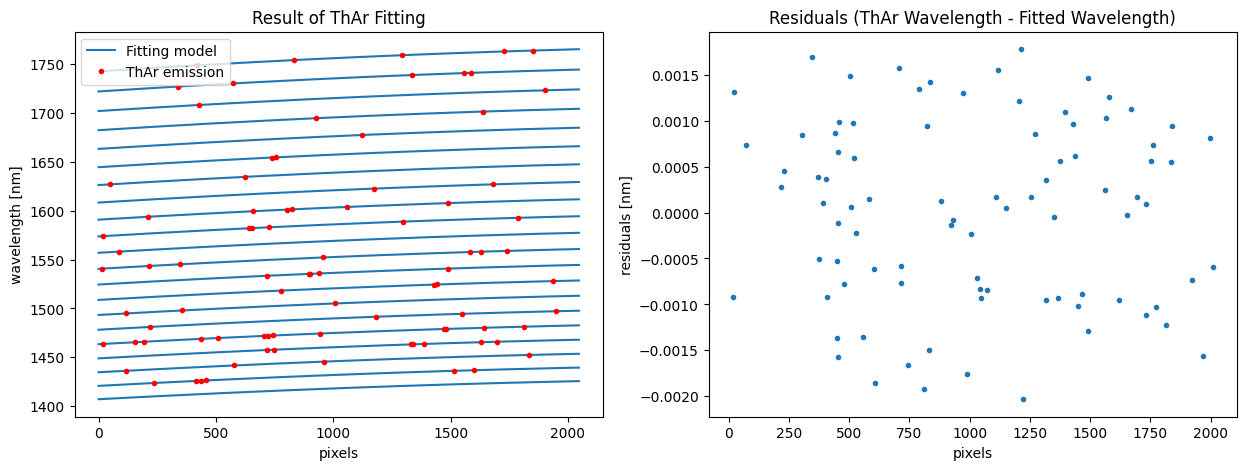

In [7]:
## THAR (ThAr-ThAr)
# Settings
if band=='h':
    rawtag='IRDAD000'
elif band=='y':
    rawtag='IRDBD000'
thar=irdstream.Stream2D("thar", datadir_thar, anadir, rawtag=rawtag, fitsid=fitsid_thar, band=band)
thar.trace = trace_mmf

# removing noise pattern
thar.clean_pattern(trace_mask=trace_mask,extin='', extout='_cp', hotpix_mask=hotpix_mask)

# wavelength calibration
thar.calibrate_wavelength()

.. _step1-4:

### Step 1-4: Creating a Normalized Flat

- This process similar to `hdsis_ecf <https://github.com/chimari/hds_iraf>`_ for HDS/Subaru data to reduce the fringe appearing in a spectrum.
- In the preparation of this process, we create the normalized flat by using `apnormalize`.
- After applying `flatten`, **'{stream_id}\_{band}\_{mmf}.fits'** (e.g., flat_star_h_m2.fits) is created in anadir, containing the extracted spectrum of flat data.

In [8]:
## FLAT
if mmf=='mmf2': # Star fiber -> FLAT_STAR
    # Settings
    flat_star=irdstream.Stream2D("flat_star", datadir_flat, anadir, fitsid=fitsid_flat_star, band=band)
    flat_star.trace = trace_mmf

    # Removing noise pattern
    flat_star.clean_pattern(trace_mask=trace_mask, extin='', extout='_cp', hotpix_mask=hotpix_mask)
    flat_star.imcomb = True # median combine

    # Extract 1D spectrum
    flat_star.flatten(hotpix_mask=hotpix_mask)

    # Flat spectrum normalized in each pixel within an aperture
    df_flatn = flat_star.apnormalize()

elif mmf=='mmf1': # Comb fiber -> FLAT_COMB
    flat_comb.trace = trace_mmf

    # Removing noise pattern
    flat_comb.clean_pattern(trace_mask=trace_mask, extin='', extout='_cp', hotpix_mask=hotpix_mask)
    flat_comb.imcomb = True # median combine

    # Extract 1D spectrum
    flat_comb.flatten(hotpix_mask=hotpix_mask)

    # Flat spectrum normalized in each pixel within an aperture
    df_flatn = flat_comb.apnormalize()

fitsid: [41804, 41806, 41808, 41810, 41812, 41814, 41816, 41818, 41820, 41822, 41824, 41826, 41828, 41830, 41832, 41834, 41836, 41838, 41840, 41842, 41844, 41846, 41848, 41850, 41852, 41854, 41856, 41858, 41860, 41862, 41864, 41866, 41868, 41870, 41872, 41874, 41876, 41878, 41880, 41882, 41884, 41886, 41888, 41890, 41892, 41894, 41896, 41898, 41900, 41902]
fitsid incremented:  [41805, 41807, 41809, 41811, 41813, 41815, 41817, 41819, 41821, 41823, 41825, 41827, 41829, 41831, 41833, 41835, 41837, 41839, 41841, 41843, 41845, 41847, 41849, 41851, 41853, 41855, 41857, 41859, 41861, 41863, 41865, 41867, 41869, 41871, 41873, 41875, 41877, 41879, 41881, 41883, 41885, 41887, 41889, 41891, 41893, 41895, 41897, 41899, 41901, 41903]
clean_pattern: output extension=_cp



  0%|                                                                                                                                                            | 0/50 [00:00<?, ?it/s]


  2%|██▉                                                                                                                                                 | 1/50 [00:00<00:40,  1.22it/s]


  4%|█████▉                                                                                                                                              | 2/50 [00:01<00:46,  1.02it/s]


  6%|████████▉                                                                                                                                           | 3/50 [00:02<00:44,  1.05it/s]


  8%|███████████▊                                                                                                                                        | 4/50 [00:03<00:40,  1.14it/s]


 10%|██████████████▊                                                                                                                                     | 5/50 [00:04<00:37,  1.20it/s]


 12%|█████████████████▊                                                                                                                                  | 6/50 [00:05<00:34,  1.28it/s]


 14%|████████████████████▋                                                                                                                               | 7/50 [00:05<00:31,  1.36it/s]


 16%|███████████████████████▋                                                                                                                            | 8/50 [00:06<00:32,  1.31it/s]


 18%|██████████████████████████▋                                                                                                                         | 9/50 [00:07<00:32,  1.27it/s]


 20%|█████████████████████████████▍                                                                                                                     | 10/50 [00:08<00:32,  1.24it/s]


 22%|████████████████████████████████▎                                                                                                                  | 11/50 [00:08<00:29,  1.32it/s]


 24%|███████████████████████████████████▎                                                                                                               | 12/50 [00:09<00:27,  1.37it/s]


 26%|██████████████████████████████████████▏                                                                                                            | 13/50 [00:10<00:26,  1.40it/s]


 28%|█████████████████████████████████████████▏                                                                                                         | 14/50 [00:10<00:25,  1.44it/s]


 30%|████████████████████████████████████████████                                                                                                       | 15/50 [00:11<00:26,  1.34it/s]


 32%|███████████████████████████████████████████████                                                                                                    | 16/50 [00:12<00:24,  1.38it/s]


 34%|█████████████████████████████████████████████████▉                                                                                                 | 17/50 [00:13<00:23,  1.41it/s]


 36%|████████████████████████████████████████████████████▉                                                                                              | 18/50 [00:13<00:22,  1.44it/s]


 38%|███████████████████████████████████████████████████████▊                                                                                           | 19/50 [00:14<00:21,  1.44it/s]


 40%|██████████████████████████████████████████████████████████▊                                                                                        | 20/50 [00:15<00:20,  1.47it/s]


 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 21/50 [00:15<00:19,  1.47it/s]


 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 22/50 [00:16<00:18,  1.49it/s]


 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 23/50 [00:17<00:19,  1.39it/s]


 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 24/50 [00:17<00:18,  1.42it/s]


 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 25/50 [00:18<00:17,  1.45it/s]


 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 26/50 [00:19<00:16,  1.48it/s]


 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 27/50 [00:19<00:15,  1.49it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 28/50 [00:20<00:14,  1.51it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 29/50 [00:21<00:14,  1.49it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 30/50 [00:21<00:13,  1.50it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 31/50 [00:22<00:13,  1.40it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 32/50 [00:23<00:12,  1.42it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 33/50 [00:24<00:11,  1.43it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 34/50 [00:24<00:10,  1.46it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 35/50 [00:25<00:10,  1.47it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 36/50 [00:25<00:09,  1.48it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 37/50 [00:26<00:08,  1.50it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 38/50 [00:27<00:07,  1.51it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 39/50 [00:27<00:07,  1.51it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 40/50 [00:28<00:06,  1.50it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 41/50 [00:29<00:05,  1.51it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 42/50 [00:29<00:05,  1.50it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 43/50 [00:30<00:04,  1.51it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 44/50 [00:31<00:04,  1.49it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 45/50 [00:32<00:03,  1.37it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 46/50 [00:32<00:02,  1.40it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 47/50 [00:33<00:02,  1.43it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 48/50 [00:34<00:01,  1.45it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 49/50 [00:34<00:00,  1.47it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.49it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.41it/s]


  0%|                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

median combine:  _cp



  0%|                                                                                                                                                            | 0/50 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 743.29it/s]


  0%|                                                                                                                                                            | 0/21 [00:00<?, ?it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13/21 [00:00<00:00, 125.45it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 121.76it/s]


  0%|                                                                                                                                                            | 0/21 [00:00<?, ?it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13/21 [00:00<00:00, 122.80it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 120.32it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.37s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.37s/it]

flatten (+ hotpix mask): output extension=_hp_m2
continuum is fitted with order_fit = 23.
median combine:  _cp



  0%|                                                                                                                                                            | 0/50 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1211.51it/s]


  0%|                                                                                                                                                            | 0/21 [00:00<?, ?it/s]


 10%|██████████████                                                                                                                                      | 2/21 [00:00<00:02,  8.72it/s]


 14%|█████████████████████▏                                                                                                                              | 3/21 [00:00<00:02,  7.28it/s]


 19%|████████████████████████████▏                                                                                                                       | 4/21 [00:00<00:02,  6.72it/s]


 24%|███████████████████████████████████▏                                                                                                                | 5/21 [00:00<00:02,  6.42it/s]


 29%|██████████████████████████████████████████▎                                                                                                         | 6/21 [00:00<00:02,  6.25it/s]


 33%|█████████████████████████████████████████████████▎                                                                                                  | 7/21 [00:01<00:02,  6.14it/s]


 38%|████████████████████████████████████████████████████████▍                                                                                           | 8/21 [00:01<00:02,  6.07it/s]


 43%|███████████████████████████████████████████████████████████████▍                                                                                    | 9/21 [00:01<00:01,  6.04it/s]


 48%|██████████████████████████████████████████████████████████████████████                                                                             | 10/21 [00:01<00:01,  6.02it/s]


 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 11/21 [00:01<00:01,  6.01it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 12/21 [00:01<00:01,  6.00it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 13/21 [00:02<00:01,  5.97it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 14/21 [00:02<00:01,  5.95it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 15/21 [00:02<00:01,  5.94it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 16/21 [00:02<00:00,  5.95it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 17/21 [00:02<00:00,  5.95it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 18/21 [00:02<00:00,  5.96it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 19/21 [00:03<00:00,  5.95it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 20/21 [00:03<00:00,  5.97it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.95it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  6.13it/s]

.. _step2:

## Step 2: Extracting the Target 1D Spectrum

From here, we will extract target spectrum.

<img src="../figures/reduc_flowchart_target.png" width=80%>

In [9]:
#--------FOR TARGET--------#
# Settings
target = irdstream.Stream2D('targets', datadir_target, anadir, fitsid=fitsid_target, band=band)
target.info = True  # show detailed info
target.trace = trace_mmf

fitsid: [41510]
fitsid incremented:  [41511]


.. _step2-1:

### Step 2-1: Removing Noise Pattern on the Detector

In [10]:
target.clean_pattern(trace_mask=trace_mask, extin='', extout='_cp', hotpix_mask=hotpix_mask)

clean_pattern: output extension=_cp



  0%|                                                                                                                                                             | 0/1 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]

.. _step2-2:

### Step 2-2: Aperture Extraction & Flat Fielding

- The ``apext_flatfield`` function extracts each order while applying flat fielding.
- This process requires the flat spectrum normalized in each pixel within an aperture (i.e., df_flatn).
- After this process, **'IRDA000..._flnhp.fits'** (when `hotpix_mask` is set) or **'IRDA000..._fln.fits'** (when `hotpix_mask = None`) is created.

In [11]:
target.apext_flatfield(df_flatn, hotpix_mask=hotpix_mask)


  0%|                                                                                                                                                             | 0/1 [00:00<?, ?it/s]


  0%|                                                                                                                                                            | 0/21 [00:00<?, ?it/s]


  5%|███████                                                                                                                                             | 1/21 [00:00<00:02,  7.82it/s]


 10%|██████████████                                                                                                                                      | 2/21 [00:00<00:02,  6.40it/s]


 14%|█████████████████████▏                                                                                                                              | 3/21 [00:00<00:02,  6.03it/s]


 19%|████████████████████████████▏                                                                                                                       | 4/21 [00:00<00:02,  5.96it/s]


 24%|███████████████████████████████████▏                                                                                                                | 5/21 [00:00<00:02,  5.89it/s]


 29%|██████████████████████████████████████████▎                                                                                                         | 6/21 [00:00<00:02,  5.87it/s]


 33%|█████████████████████████████████████████████████▎                                                                                                  | 7/21 [00:01<00:02,  5.88it/s]


 38%|████████████████████████████████████████████████████████▍                                                                                           | 8/21 [00:01<00:02,  5.87it/s]


 43%|███████████████████████████████████████████████████████████████▍                                                                                    | 9/21 [00:01<00:02,  5.87it/s]


 48%|██████████████████████████████████████████████████████████████████████                                                                             | 10/21 [00:01<00:01,  5.85it/s]


 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 11/21 [00:01<00:01,  5.85it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 12/21 [00:02<00:01,  5.86it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 13/21 [00:02<00:01,  5.86it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 14/21 [00:02<00:01,  5.86it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 15/21 [00:02<00:01,  5.86it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 16/21 [00:02<00:00,  5.86it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 17/21 [00:02<00:00,  5.87it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 18/21 [00:03<00:00,  5.88it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 19/21 [00:03<00:00,  5.87it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 20/21 [00:03<00:00,  5.87it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.90it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/it]

pixel = -2, Mean = 0.84721
pixel = -1, Mean = 1.35783
pixel = 0, Mean = 1.46715
pixel = 1, Mean = 1.34046
pixel = 2, Mean = 0.77173
pixel = 3, Mean = 0.17888


.. _step2-3:

### Step 2-3: Assigning Wavelength to the Extracted Spectrum

- The `dispcor` function assigns wavelength solution to the extracted spectrum.
- Please change the ``extin`` option to ``extin='_flnhp'`` or ``extin='_fln'`` depending on the previous process.
- After this process, **'w..._m?.dat'** is created, with data format: `$1: Wavelength [nm]`, `$2: Order`, `$3: Counts`.

dispcor: output spectrum= w41511_m2.dat


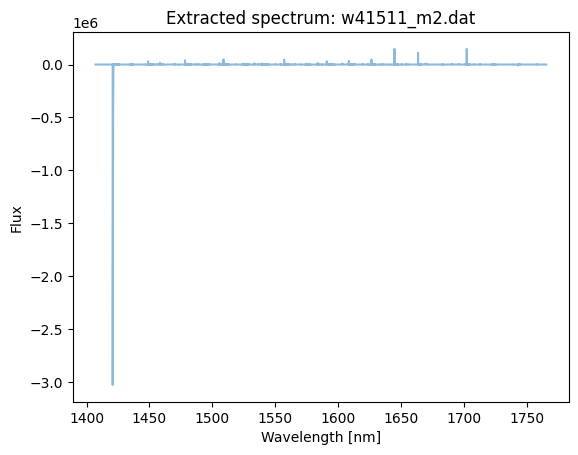

In [12]:
target.dispcor(master_path=thar.anadir, extin='_flnhp')

.. _step2-4:

### Step 2-4: Creating the Blaze Function

- The blaze function is created from FLAT spectrum to ''normalize'' the spectra.
- After this process, **'wblaze_{band}_{mmf}.dat'** is created.


  0%|                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

median combine:  _cp



  0%|                                                                                                                                                            | 0/50 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1064.24it/s]


  0%|                                                                                                                                                            | 0/21 [00:00<?, ?it/s]


 10%|██████████████                                                                                                                                      | 2/21 [00:00<00:02,  8.69it/s]


 14%|█████████████████████▏                                                                                                                              | 3/21 [00:00<00:02,  7.28it/s]


 19%|████████████████████████████▏                                                                                                                       | 4/21 [00:00<00:02,  6.68it/s]


 24%|███████████████████████████████████▏                                                                                                                | 5/21 [00:00<00:02,  6.40it/s]


 29%|██████████████████████████████████████████▎                                                                                                         | 6/21 [00:00<00:02,  6.21it/s]


 33%|█████████████████████████████████████████████████▎                                                                                                  | 7/21 [00:01<00:02,  6.11it/s]


 38%|████████████████████████████████████████████████████████▍                                                                                           | 8/21 [00:01<00:02,  6.05it/s]


 43%|███████████████████████████████████████████████████████████████▍                                                                                    | 9/21 [00:01<00:01,  6.00it/s]


 48%|██████████████████████████████████████████████████████████████████████                                                                             | 10/21 [00:01<00:01,  5.96it/s]


 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 11/21 [00:01<00:01,  5.93it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 12/21 [00:01<00:01,  5.93it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 13/21 [00:02<00:01,  5.92it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 14/21 [00:02<00:01,  5.91it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 15/21 [00:02<00:01,  5.89it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 16/21 [00:02<00:00,  5.90it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 17/21 [00:02<00:00,  5.90it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 18/21 [00:02<00:00,  5.91it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 19/21 [00:03<00:00,  5.90it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 20/21 [00:03<00:00,  5.90it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.90it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  6.08it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.14s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.14s/it]

pixel = -2, Mean = 0.84721
pixel = -1, Mean = 1.35783
pixel = 0, Mean = 1.46715
pixel = 1, Mean = 1.34046
pixel = 2, Mean = 0.77173
pixel = 3, Mean = 0.17888


dispcor: output spectrum= wblaze_h_m2.dat


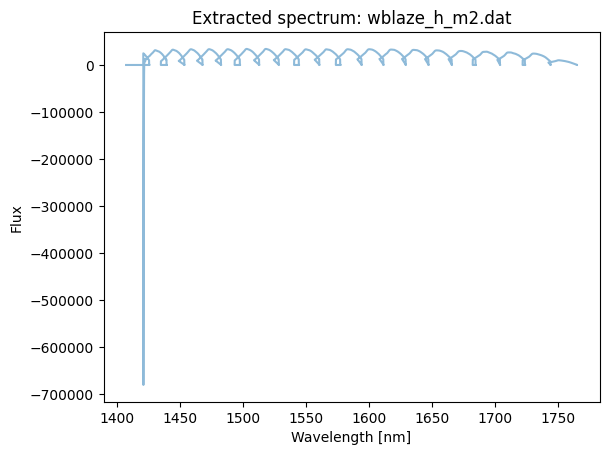

In [13]:
# blaze function
if mmf=='mmf2':
    flat_star.apext_flatfield(df_flatn, hotpix_mask=hotpix_mask)
    flat_star.dispcor(master_path=thar.anadir)
elif mmf=='mmf1':
    flat_comb.apext_flatfield(df_flatn, hotpix_mask=hotpix_mask)
    flat_comb.dispcor(master_path=thar.anadir)

.. _step2-5:

### Step 2-5: Normalizing the Spectra

- Normalize the target spectrum by dividing it by the blaze function.
- After `normalize1D`, the normalized spectrum (**nw..._m?.dat**) and the order-combined spectrum (**ncw..._m?.dat**) are created.
    - Data formats are: 
        - Normalized (**nw**): `$1: Wavelength [nm]`, `$2: Order`, `$3: Counts`, `$4: S/N`, `$5: Uncertainties`
        - Order-combined (**ncw**): `$1: Wavelength [nm]`, `$2: Counts`, `$3: S/N`, `$4: Uncertainties`
- For the order-combined spectra: There are overlapping wavelengths at the edges of orders, so we "normalize" by summing up the flux in these regions to improve the signal-to-noise ratio.

Using default readout Noise : 12
readout noise of IRD detectors: ~12e- (10min exposure)


normalize1D: output normalized 1D spectrum= nw41511_m2.dat


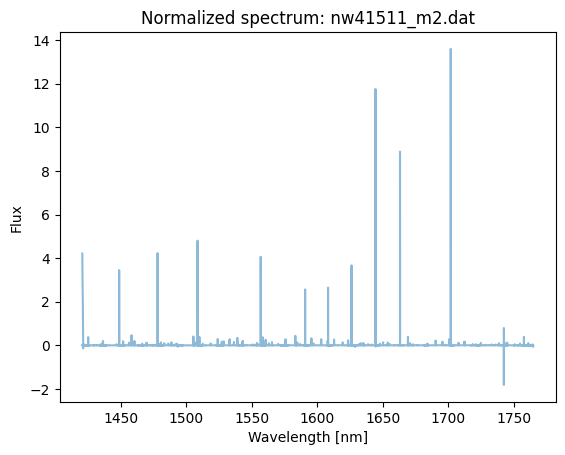

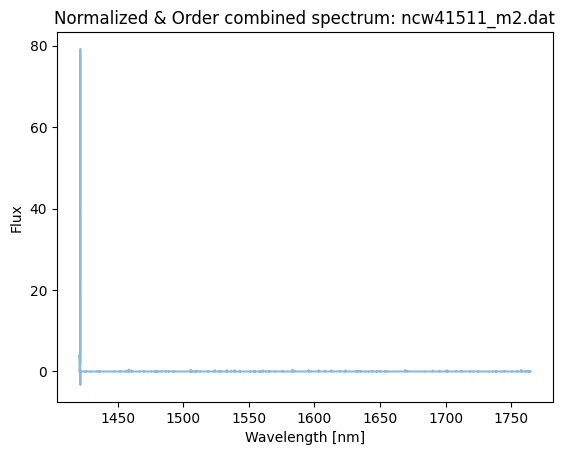

In [14]:
# combine & normalize
if mmf=='mmf2':
    target.normalize1D(master_path=flat_star.anadir, readout_noise_mode=readout_noise_mode)
elif mmf=='mmf1':
    target.normalize1D(master_path=flat_comb.anadir, readout_noise_mode=readout_noise_mode)

This concludes the data reduction process!

See :doc:`./plot_spec` page for detailed explanations of output spectra.